In [1]:
import pandas as pd
import numpy as np
from os.path import join
from datetime import datetime, timezone
from twarc import Twarc2

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

import twitter_functions as tf

In [2]:
src = "../data/twitter/US_politician_twitter_accounts/clean"
dst = "../data/twitter/US_politician_twitter_timelines"

In [3]:
handles = pd.read_csv(join(src, "congress-member-unique-twitter-handles_114-117.csv"))

# Get user IDs

In [13]:
name = "michaela"
credentials = tf.get_twitter_API_credentials(namelist=[name])
client = Twarc2(bearer_token=credentials[name])

In [51]:
users = pd.DataFrame()
batch_size = 100
N_batches = int(len(handles) / batch_size)

for batch in range(N_batches + 1):
    print(f"processing batch {batch}")
    batch_handles = handles["handle"][batch * batch_size:(batch + 1) * batch_size]
    for user_bunch in client.user_lookup(batch_handles.values, usernames=True):
        for user in user_bunch["data"]:
            
            try:
                location = user["location"]
            except KeyError:
                location = np.nan
            
            row = {"id":user["id"],
                   "handle":user["username"],
                   "name":user["name"],
                   "created_at":user["created_at"],
                   "verified":user["verified"],
                   "protected":user["protected"],
                   "location":location,
                   "description":user["description"],
                   "downloaded":str(datetime.today()).split(".")[0],
                   "followers_count":user["public_metrics"]["followers_count"],
                   "following_count":user["public_metrics"]["following_count"],
                   "tweet_count":user["public_metrics"]["tweet_count"],
                   "listed_count":user["public_metrics"]["listed_count"]}
            users = users.append(row, ignore_index=True)
        
for col in ["followers_count", "following_count", "id", "listed_count", 
            "protected", "tweet_count", "verified"]:
    users[col] = users[col].astype(int)
users.to_csv(join(src, "congress-member-unique-twitter-accounts_114-117.csv"), index=False)

processing batch 0
processing batch 1
processing batch 2
processing batch 3
processing batch 4
processing batch 5
processing batch 6
processing batch 7
processing batch 8
processing batch 9
processing batch 10
processing batch 11


In [52]:
diff = list(set(handles["handle"]).difference(set(users["handle"])))
print(f"{len(diff)} user profiles could not be retrieved")

102 user profiles could not be retrieved


# Get user timelines

In [46]:
users = pd.read_csv(join(src, "congress-member-unique-twitter-accounts_114-117.csv"))
remaining_users = list(users["id"].values)

In [47]:
N_tasks = 5
namelist = ['michaela', 'simon', 'johanness', 'flo', 'caspar']
print(f"using keys from {namelist}")
credentials = tf.get_twitter_API_credentials(namelist=namelist)
# apparently the API does not return timelines before 2010-11-06 (tested)
start = datetime(2010, 11, 6, 0, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2021, 12, 14, 0, 0, 0, 0, tzinfo=timezone.utc)
task_info = tf.create_crawlinfo(N_tasks, remaining_users, 
                                start, end, dst, credentials)

using keys from ['michaela', 'simon', 'johanness', 'flo', 'caspar']


In [48]:
number_of_cores = len(namelist)
pool = Pool(number_of_cores)

for task in tqdm(pool.imap_unordered(func=tf.get_user_timelines,
                                     iterable=task_info),
                                     total=len(task_info)):
        pass

100%|██████████| 5/5 [2:06:51<00:00, 1522.20s/it]  


# Collect user timelines

In [4]:
from importlib import reload
reload(tf)

<module 'twitter_functions' from '/home/jana/Projects/CSS_honesty/analysis/code/twitter_functions.py'>

In [5]:
users = pd.read_csv(join(src, "congress-member-unique-twitter-accounts_114-117.csv"))

In [9]:
def extract_information(ID):
    tmp = pd.DataFrame()
    try:
        json_timeline = tf.load_json_timeline(ID, dst)
    except FileNotFoundError:
        return tmp
    
    for tl_obj in json_timeline:
        tmp = pd.concat([tmp, tf.unravel_data(tl_obj)])
    return tmp

In [15]:
str(start)

'2010-11-06 00:00:00+00:00'

In [10]:
start = datetime(2010, 11, 6, 0, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2021, 12, 14, 0, 0, 0, 0, tzinfo=timezone.utc)
dst = "../data/twitter/"

number_of_cores = 10
pool = Pool(number_of_cores)
timelines = pd.DataFrame()

for tmp in tqdm(pool.imap_unordered(func=extract_information, 
                    iterable=users["id"].values), total=len(users)):
        timelines = pd.concat([timelines, tmp])

fname = f"combined_US_politician_twitter_timelines_{str(start).split(" ")[0]}_to_{str(end).split(" ")[0]}_raw.csv.gzip"
timelines.to_csv(join(dst, fname), compression="gzip", index=False)

100%|██████████| 1065/1065 [40:02<00:00,  2.26s/it]


In [11]:
timelines

,author_id,conversation_id,created_at,expanded_urls,geo,id,lang,like_count,quote_count,reference_type,reply_count,retweet_count,text,urls
0,2982232408,576588442504720384,2015-03-14T03:39:31.000Z,[],NaN,576588442504720384,ru,0.0,1.0,[],0.0,0.0,ты не рожден для лунной доли,[]
1,2982232408,576032750123253760,2015-03-12T14:51:24.000Z,[],NaN,576032750123253760,uk,0.0,0.0,[],0.0,0.0,"Я ж себе забуваю,коли п'ю безнастанно.",[]
2,2982232408,574964793444073472,2015-03-09T16:07:43.000Z,[],NaN,574964793444073472,ru,0.0,0.0,[],0.0,0.0,Тихо ходики стучат,[]
3,2982232408,574192107109421056,2015-03-07T12:57:20.000Z,[],NaN,574192107109421056,ru,0.0,0.0,[],0.0,0.0,Помнишь ли – в этом кафе под зонтиком звонко у...,[]
4,2982232408,573223746720403456,2015-03-04T20:49:25.000Z,[],NaN,573223746720403456,ru,0.0,0.0,[],0.0,0.0,Мыши погрызли лепёшку.,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,779104195,1268286575592370178,2020-06-03T21:00:57.000Z,[],NaN,1268286575592370178,en,0.0,0.0,[retweeted],0.0,3.0,RT @1370WCOA: #NewsRoundup – The national res...,[]
41,779104195,1268285214565863424,2020-06-03T20:55:33.000Z,[],NaN,1268285214565863424,en,0.0,0.0,[retweeted],0.0,10.0,RT @knssradio: : @SeanHannity - #NewsRoundup ...,[]
42,779104195,1268199775578533889,2020-06-03T15:16:03.000Z,[https://twitter.com/BurgessOwens/status/12681...,NaN,1268199775578533889,en,223.0,3.0,[],10.0,38.0,Trust in the Lord with all your heart. https:/...,[https://t.co/LWUKAhp2R3]
43,779104195,1268033455360786436,2020-06-03T06:57:34.000Z,[],NaN,1268074330878930944,en,290.0,1.0,[replied_to],8.0,25.0,@realDonaldTrump @IngrahamAngle @FoxNews Thank...,[]


# Clean user timelines

In [18]:
reload(tf)

<module 'twitter_functions' from '/home/jana/Projects/CSS_honesty/analysis/code/twitter_functions.py'>

In [3]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2021-12-14_raw.csv.gzip"
src = "../data/twitter/"
timelines = pd.read_csv(join(src, fname), compression="gzip")

/home/jana/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,4,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
N = len(timelines)
timelines = timelines[timelines["lang"] == "en"]
timelines = timelines.dropna(subset=["id"])
print(f"dropped {N - len(timelines)} non-english Tweets")

dropped 53524 non-english Tweets


In [5]:
timelines["reference_type"] = timelines["reference_type"].apply(lambda x: eval(x))

In [6]:
timelines["retweeted"] = timelines["reference_type"].apply(tf.check_retweet)
timelines["quoted"] = timelines["reference_type"].apply(tf.check_quoted)
timelines["reply"] = timelines["reference_type"].apply(tf.check_reply)
timelines = timelines.drop(columns=["reference_type"])

In [29]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2021-12-14_clean.csv.gzip"
dst = "../data/twitter/"
timelines.to_csv(join(dst, fname), index=False, compression="gzip")

## Corpus statistics

In [9]:
print(f"number of tweets in the corpus: {len(timelines)}")
print("number of original in the corpus: {}"\
      .format(len(timelines[(timelines["retweeted"] == False) &\
                            (timelines["quoted"] == False) &\
                            (timelines["reply"] == False)])))
print("number of quoted tweets in the corpus: {}"\
      .format(len(timelines[timelines["quoted"] == True])))
print("number of replies in the corpus: {}"\
      .format(len(timelines[timelines["reply"] == True])))
print("number of retweets in the corpus: {}"\
      .format(len(timelines[timelines["retweeted"] == True])))

number of tweets in the corpus: 2562091
number of original in the corpus: 1460214
number of quoted tweets in the corpus: 249014
number of replies in the corpus: 232321
number of retweets in the corpus: 622903


In [21]:
timelines["year"] = pd.to_datetime(timelines["created_at"]).dt.year

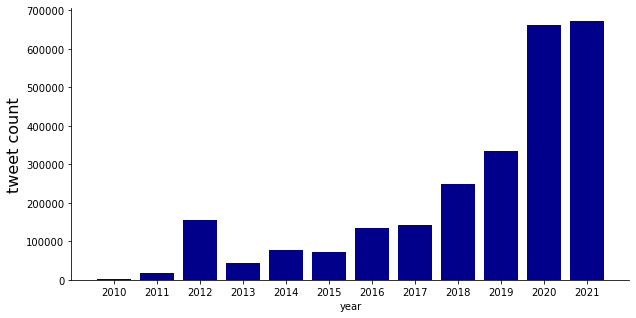

In [47]:
import matplotlib.pyplot as plt
import numpy as np
counts, years = np.histogram(timelines["year"], bins=range(2010, 2022))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(timelines["year"].value_counts(ascending=True).index,
       timelines["year"].value_counts(ascending=True).values,
       color="DarkBlue")
ax.set_xticks(range(2010, 2022))
ax.set_ylabel("tweet count", fontsize=16)
ax.set_xlabel("year", fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("../plots/corpus_tweets_year_count.pdf")